In [ ]:
import os

os.chdir("../")
print(os.getcwd())

In [4]:
!~/anaconda3/envs/dreamer_cyl2/lib/

/bin/bash: which: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `which'
/bin/bash: module: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `module'
/bin/bash: scl: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `scl'
/bin/bash: ml: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `ml'
/bin/bash: /rds/general/user/pg221/home/anaconda3/envs/dreamer_cyl2/lib/: Is a directory


In [2]:
!echo $LD_LIBRARY_PATH
os.environ['LD_LIBRARY_PATH'] = '~/anaconda3/envs/dreamer_cyl2/lib/:$LD_LIBRARY_PATH'
print(os.environ['LD_LIBRARY_PATH'])

/bin/bash: which: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `which'
/bin/bash: module: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `module'
/bin/bash: scl: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `scl'
/bin/bash: ml: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `ml'

~/anaconda3/envs/dreamer_cyl2/lib/:$LD_LIBRARY_PATH


In [ ]:
# python main_cyl.py --imag_horizon 15 --envs.amount 50 --jax.platform cpu \
#                    --logdir  ~/PhD_projects2/dreamer_flows/dreamer/logdir/Cyl/First_Test

import subprocess

# Define the command to run the Python script
command = 'python run_files/main_train_eval_cyl.py --jax.platform cpu \
               --envs.amount 2 --envs.parallel process\
               --loss_scales.reward 10 \
               --run.eval_every 20 \
               --imag_horizon 20 \
               --rssm.deter 128 --.*\.units=128 --.*\.layers=1 \
               --cyl.random_start 10 \
               --logdir_dirname CYl_Exp/Test \
               --logdir_expname test_notebook '

# Run the command in a subprocess, using the current environment with the updated variable
result = subprocess.run(command, shell=True, env=os.environ)

# Check the result
print(f'Return code: {result.returncode}')

# Read Drag values while training

In [3]:
# def load(filename=None, keys=None):
# #     filename = path.Path(filename)
#     print(f'Loading checkpoint: {filename}')
#     file = open(filename, 'rb')
#     load_data = pickle.load(file)
# #     keys = tuple(data.keys() if keys is None else keys)
#     return load_data
# #     for key in keys:
# #       if key.startswith('_'):
# #         continue
# #       try:
# #         values[key].load(data[key])
# #       except Exception:
# #         print(f'Error loading {key} from checkpoint.')
# #         raise
# #     if self._log:
# #       age = time.time() - data['_timestamp']
# #       print(f'Loaded checkpoint from {age:.0f} seconds ago.')

# data = load(filename = "logdir/Cyl/First_Test/events.out.tfevents.1717606486.cx3-1-0.cx3.hpc.ic.ac.uk.2498444.0.v2")
# print(data.keys())

In [4]:
import warnings
import dreamerv3
from dreamerv3 import embodied
warnings.filterwarnings('ignore', '.*truncated to dtype int32.*')

print("Reading config", flush =True)

# See configs.yaml for all options.
import warnings
import dreamerv3
from dreamerv3 import embodied
warnings.filterwarnings('ignore', '.*truncated to dtype int32.*')

print("Reading config", flush =True)
# See configs.yaml for all options.
config = embodied.Config(dreamerv3.configs['defaults'])
config = config.update(dreamerv3.configs['small'])
config = config.update({
'logdir': '~/PhD_projects2/dreamer_flows/dreamer/logdir/Cyl/First_Test',
'run.train_ratio': 32,
'run.log_every': 30,  # seconds
'run.from_checkpoint': "logdir/Cyl/First_Test/checkpoint.ckpt",
'batch_size': 16,
'batch_length': 8,
'jax.prealloc': False,

'encoder.mlp_keys': 'vector',
#   'encoder.mlp_units': 512,

'decoder.mlp_keys': 'vector',
#   'decoder.mlp_units': 512,

'encoder.cnn_keys': '$^',
'decoder.cnn_keys': '$^',

#   'reward_head.units': 512,
#   'cont_head.units': 512,

'model_opt.lr': 1e-4,

'jax.platform': 'cpu',
'wrapper.length': 0,


# 'envs.amount': 8
})

# config = embodied.Flags(config).parse()

logdir = embodied.Path(config.logdir)
step = embodied.Counter()
logger = embodied.Logger(step, [
embodied.logger.TerminalOutput(),
embodied.logger.JSONLOutput(logdir, 'metrics.jsonl'),
embodied.logger.TensorBoardOutput(logdir),

])

print("confid jax.platform: ", config.jax.platform)

2024-06-11 00:16:41.307552: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-11 00:16:47.486506: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Reading config
Reading config
confid jax.platform:  cpu


In [5]:
#   import crafter
import gym
from embodied.envs import from_gym

from cyl.simulation_base.env import resume_env
import numpy as np

print("Setting Up Environment", flush =True)
sim_log_name = config.logdir.split("/")[-1]
env  = resume_env(plot=False, single_run=True, dump_CL=False, dump_vtu=100, sim_log_name = sim_log_name+"test")

env = from_gym.FromGym(env, obs_key='vector')  # Or obs_key='vector'.

print("wrapping env", flush =True)
env = dreamerv3.wrap_env(env, config)

print("batching env", flush =True)
env = embodied.BatchEnv([env], parallel=False)
print("environment has been set", flush =True)

agent = dreamerv3.Agent(env.obs_space, env.act_space, step, config)
print("agent has been created", flush =True)

replay = embodied.replay.Uniform(
  config.batch_length, config.replay_size, logdir / 'replay')
print("replay has been created", flush =True)

args = embodied.Config(
  **config.run, logdir=config.logdir,
  batch_steps=config.batch_size * config.batch_length)
print("args have been created", flush =True)

--------------------------------------------------------------------------
No OpenFabrics connection schemes reported that they were able to be
used on a specific port.  As such, the openib BTL (OpenFabrics
support) will be disabled for this port.

  Local host:           cx3-1-29
  Local device:         mlx5_0
  Local port:           1
  CPCs attempted:       rdmacm, udcm
--------------------------------------------------------------------------
bash: which: line 1: syntax error: unexpected end of file
bash: error importing function definition for `which'
bash: module: line 1: syntax error: unexpected end of file
bash: error importing function definition for `module'
bash: scl: line 1: syntax error: unexpected end of file
bash: error importing function definition for `scl'
bash: ml: line 1: syntax error: unexpected end of file
bash: error importing function definition for `ml'
bash: which: line 1: syntax error: unexpected end of file
bash: error importing function definition for `whic

iUFL can be obtained from https://github.com/MiroK/ufl-interpreter
Setting Up Environment
Number of probes: 64
test cwd env:  /rds/general/user/pg221/home/PhD_projects2/dreamer_flows/dreamer
Simulated 1215 iterations before starting the control
--- done buffers initialisation ---
wrapping env
batching env
environment has been set
Encoder CNN shapes: {}
Encoder MLP shapes: {'vector': (66,)}
Decoder CNN shapes: {}
Decoder MLP shapes: {'vector': (66,)}


2024-06-11 00:18:30.595789: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


JAX devices (1): [CpuDevice(id=0)]
Policy devices: TFRT_CPU_0
Train devices:  TFRT_CPU_0
Tracing train function.
Optimizer model_opt has 16,553,794 variables.
Optimizer actor_opt has 1,052,676 variables.
Optimizer critic_opt has 1,181,439 variables.
agent has been created
replay has been created
args have been created


Loading Checkpoint Model

In [6]:
checkpoint = embodied.Checkpoint()
checkpoint.agent = agent
checkpoint.load('logdir/Cyl/First_Test/checkpoint.ckpt', keys=['agent'])

Loading checkpoint: logdir/Cyl/First_Test/checkpoint.ckpt
Loaded checkpoint from 196040 seconds ago.


Evaluating model with the environment

In [7]:
policy = lambda *args: agent.policy(*args, mode='eval')

In [8]:
from embodied.core.basics import convert
import collections

#initializing actions

_acts = {k: convert(np.zeros((len(env),) + v.shape, v.dtype))
        for k, v in env.act_space.items()}
_acts['reset'] = np.ones(len(env), bool)
_eps = [collections.defaultdict(list) for _ in range(len(env))]
_state = None


print(np.ones(len(env), bool))

[ True]


In [9]:
from tqdm import tqdm
obs_total = [] 
acts_total = []
control_time = 200
# acts['reset'] = [True]
# obs = env.reset()
for i in tqdm(range(control_time)):
    #take a step
    assert all(len(x) == len(env) for x in _acts.values())
    acts = {k: v for k, v in _acts.items() if not k.startswith('log_')}
    obs  = env.step(acts)

    #read observation
    obs = {k: convert(v) for k, v in obs.items()}
    assert all(len(x) == len(env) for x in obs.values()), obs
    acts, _state = policy(obs, _state)
    acts = {k: convert(v) for k, v in acts.items()}
    
    acts['reset'] = obs['is_last'].copy()
    _acts = acts
    acts_total.append(acts)
#     print(f"{i}: obs: ", obs)
    obs_total.append(obs)
    

  0%|          | 0/200 [00:00<?, ?it/s]

Number of probes: 64
test cwd env:  /rds/general/user/pg221/home/PhD_projects2/dreamer_flows/dreamer
Simulated 727 iterations before starting the control
Tracing policy function.
Tracing policy function.


100%|██████████| 200/200 [15:04<00:00,  4.52s/it]


In [29]:
#Collecting Reward and observations
import matplotlib.pyplot as plt

obs_data = obs_total[0]['vector']
obs_reward = obs_total[0]['reward']
acts_data = acts_total[0]['action']
for i in range(1,control_time):
    obs_data   = np.concatenate((obs_data  , obs_total[i]['vector']), axis = 0)
    obs_reward = np.concatenate((obs_reward, obs_total[i]['reward']), axis = 0)
    acts_data  = np.concatenate((acts_data , acts_total[i]['action']) , axis = 0)

# total_obs_data = np.concatenate((u_hist, obs_data), axis = 0)

print("obs_data shape: ", obs_data.shape)
# print("total_obs_data shape: ", total_obs_data.shape)
print("obs_reward shape: ", obs_reward.shape)
print("acts_data shape: ", acts_data.shape)

obs_data shape:  (400, 66)
obs_reward shape:  (400,)
acts_data shape:  (400, 2)


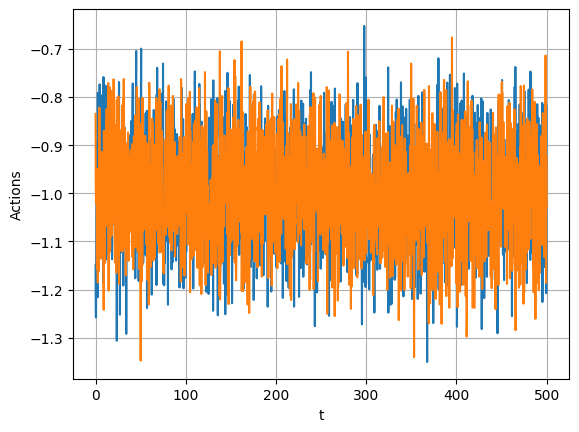

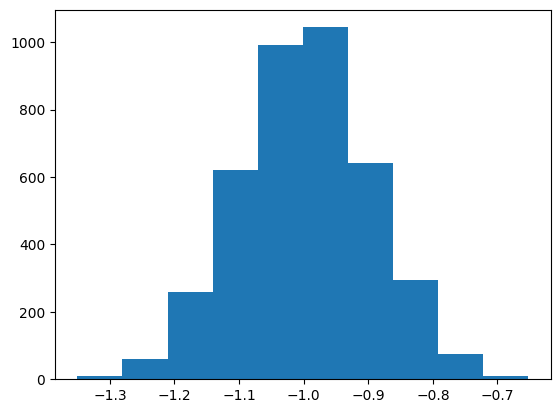

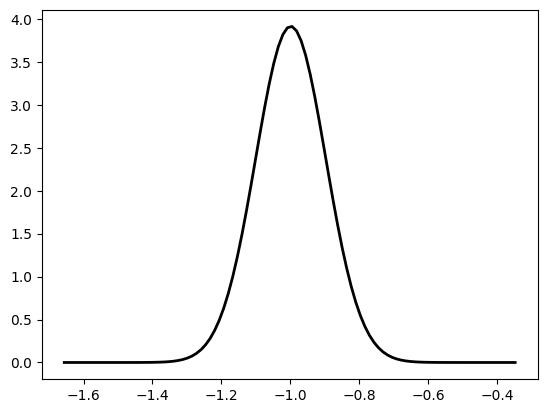

In [27]:
plt.figure()
action_step_dt = 0.25
plt.plot(np.arange(acts_data.shape[0])*action_step_dt,acts_data)
plt.grid()
plt.xlabel("t")
plt.ylabel("Actions")

plt.figure()
plt.hist(acts_data.flatten())

plt.figure()
from scipy.stats import norm
mu, std = norm.fit(acts_data.flatten())

# Generate points on the x-axis
xmin = acts_data.flatten().min() - 3 * std
xmax = acts_data.flatten().max() + 3 * std
x = np.linspace(xmin, xmax, 100)

# Generate the PDF values
p = norm.pdf(x, mu, std)

# Plot the PDF curve
plt.plot(x, p, 'k', linewidth=2)